In [1]:
import Pkg; Pkg.activate(@__DIR__); Pkg.instantiate()
#import Pkg; Pkg.activate(joinpath(@__DIR__,"..")); Pkg.instantiate()

  Activating environment at `~/Desktop/PHD2022/Autumn/CSE 579/CS_project/LQ_Game_Solver/CS_project/Project.toml`


In [2]:
using LinearAlgebra
using Plots
using SparseArrays
#using ControlSystems

In [77]:
c = 0.0
m = 1.0
function point_mass(state, u)
    x = state[1]                #x_1 = ẋ
    ẋ = state[2]
    ẍ = -(c/m)*x[2] + u[1]/(m)  #x_2 = ẍ = (-c/m)ẋ + u/m 
    y = state[3]
    ẏ = state[4]
    ÿ = -(c/m)*x[4] + u[2]/(m)  #x_2 = ẍ = (-c/m)ẋ + u/m 
    # dx[3] = x[3]
    # dx[4] = -(c/m)*x[3] + u(t)/(m)  #x_2 = ẍ = (-c/m)ẋ + u/m
    return [ẋ; ẏ; ẍ; ÿ]
end

point_mass (generic function with 1 method)

#### Point Mass Discrete

$$ \frac{d}{dt}x = Ax + \sum Bu$$

Single 2D point mass:
$$\frac{d}{dt}\begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & 0 & -c/m & 0 \\ 0 & 0 & 0 & -c/m \end{bmatrix}
 \begin{bmatrix} x \\ y \\ \dot{x} \\ \dot{y}\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m & 0 \\ 0 & 1/m \end{bmatrix}
 \begin{bmatrix} u_x \\ u_y\end{bmatrix} $$

two 2D point masses:
$$\frac{d}{dt}\begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} =  
 \begin{bmatrix} 0 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & 1 & 0 & 0 & 0 & 0 \\ 
                0 & 0 & -c/m_1 & 0 & 0 & 0 & 0 & 0\\ 
                0 & 0 & 0 & -c/m_1 & 0 & 0 & 0 & 0\\
                0 & 0 & 0 & 0 & 0 & 0 & 1 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & 1\\ 
                0 & 0 & 0 & 0 & 0 & 0 & -c/m_2 & 0\\ 
                0 & 0 & 0 & 0 & 0 & 0 & 0 & -c/m_2\\ \end{bmatrix}
 \begin{bmatrix} x_1 \\ y_1 \\ \dot{x}_1 \\ \dot{y}_1 \\ x_2 \\ y_2 \\ \dot{x}_2 \\ \dot{y}_2\end{bmatrix} + 
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 1/m_1 & 0 \\ 0 & 1/m_1 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0\end{bmatrix}
 \begin{bmatrix} u_x^1 \\ u_y^1 \end{bmatrix} +
 \begin{bmatrix} 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 0 & 0 \\ 1/m_2 & 0 \\ 0 & 1/m_2\end{bmatrix}
 \begin{bmatrix} u_x^2 \\ u_y^2 \end{bmatrix}  $$


### State and input Jacobian of 2 point masses

In [104]:
m₁ = 1
m₂ = 1
c = 0
A1 = sparse([0 0 1 0; 0 0 0 1; 0 0 (-c/m₁) 0; 0 0 0 (-c/m₁)])
A2 = sparse([0 0 1 0; 0 0 0 1; 0 0 (-c/m₂) 0; 0 0 0 (-c/m₂)])
A = blockdiag(A1, A2)
B1 = sparse([0 0; 0 0; (1/m₁) 0; 0 (1/m₁); 0 0; 0 0; 0 0; 0 0])  #Control Jacobian for point mass 1
B2 = sparse([0 0; 0 0; 0 0; 0 0; 0 0; 0 0; (1/m₂) 0; 0 (1/m₂)])    #Control Jacobian for point mass 2

8×2 SparseMatrixCSC{Float64, Int64} with 2 stored entries:
  ⋅    ⋅ 
  ⋅    ⋅ 
  ⋅    ⋅ 
  ⋅    ⋅ 
  ⋅    ⋅ 
  ⋅    ⋅ 
 1.0   ⋅ 
  ⋅   1.0

### Discretize

In [105]:
dt = 0.01 #step size
H = 30.0  #Horizon
k_steps = trunc(Int, H/dt) 

Ad = dt .* A + I    #discretize (zero order hold)
B1d = dt .*B1   #discrete (zero order hold)
B2d = dt .*B2;   #discrete (zero order hold)

In [106]:
Q1 = sparse(zeros(8,8)) #state cost for point mass 1
Q1[1,1] = 1; Q1[2,2] = 1; Q1[3,3] = 1; Q1[4,4] = 1;
Q2 = sparse(zeros(8,8))   #state cost for point mass 2
Q2[5,5] = 1; Q2[6,6] = 1; Q2[7,7] = 1; Q2[8,8] = 1;
R11 = I(2)    #Control cost for player 1
R22 = I(2)    #Contorl cost for player 2
R12 = sparse(zeros(2,2))    #Control cost for player 1 associated with player 2's controls
R21 = sparse(zeros(2,2))    #Control cost for player 2 associated with player 1's controls


2×2 SparseMatrixCSC{Float64, Int64} with 0 stored entries:
  ⋅    ⋅ 
  ⋅    ⋅ 

In [107]:
B1d' * Q1 * Ad

2×8 SparseMatrixCSC{Float64, Int64} with 2 stored entries:
  ⋅    ⋅   0.01   ⋅     ⋅    ⋅    ⋅    ⋅ 
  ⋅    ⋅    ⋅    0.01   ⋅    ⋅    ⋅    ⋅ 

In [108]:
x0 = [0; 0; 1; 0; 0; 0; 0; 0]
xref = [2; 1; 1; 2; 0; 0; 0; 0]
function cost(xref, x0)
    x_k = copy(xref - x0)
    c1 = 0
    c2 = 0
    for k in length(k_steps)
        K1 = -sparse([0.1 0.1 0.1 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0])
        K2 = -sparse([0.3 -0.1 0.2 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0])
        u1 = K1*x_k
        u2 = K2*x_k
        x_k = Ad*x_k + B1d*u1 + B2d*u2
        c1 += x_k'*Q1*x_k + u1'*R11*u1 + u2'*R12*u2
        c2 += x_k'*Q2*x_k + u2'*R22*u2 + u2'*R21*u2
    end
    return c1,c2
end

cost (generic function with 1 method)

In [109]:
c1, c2 = cost(xref, x0)

(9.130409, 0.250025)

\begin{bmatrix} S11 & S12 \\ S21 & S22 \end{bmatrix}
\begin{bmatrix} P1 \\ P2 \end{bmatrix} = 
\begin{bmatrix} Y1 \\ Y2 \end{bmatrix}

\begin{bmatrix} R^{11} + (B^{1'} * V₁ * B^1) & (B^{1'} * V₁ * B^2) \\ (B^{2'} * V_2 * B^1) & R^{22} + (B^{2'} * V_2 * B^2) \end{bmatrix}

In [110]:
k_steps

3000

In [111]:
n = 8 #8 states
m = 2 #2 controls
function lqGame!(n, m)
    """
    Input
    Ad is an nxn matrix (8x8)
    B1d is an nxm matrix (8x2)
    B2d is an nxm matrix (8x2)
    u is mx1 (2x1)
    Q1 is an nxn matrix (8x8)
    Q2 is an nxn matrix (8x8)
    R11 is an mxm matrix (2x2)
    R12 is an mxm matrix (2x2)
    R21 is an mxm matrix (2x2)
    R22 is an mxm matrix (2x2)
    Output
    P₁ is an mxn matrix (2x8)
    P₂ is an mxn matrix (2x8)
    """

    V₁ = copy(Q1) #at last time step
    V₂ = copy(Q2) #at last time step
    P₁ = zeros(k_steps, n*m)
    P₂ = zeros(k_steps, n*m)
    #α₁ = zeros(T[1], m)
    #α₂ = zeros(T[1], m)

    for t in 1:k_steps
        # solving for Ps, check equation 19 in document
        # Player 1
        S11 = R11 + (B1d' * V₁ * B1d) #2x2
        S12 = B1d' * V₁ * B2d # 2x2
        S22 = R22 + (B2d' * V₂ * B2d)
        S21 = B2d' * V₂ * B1d 
        S = [S11 S12; S21 S22] # 4x4
        Y1 = B1d' * V₁ * Ad # 2x8
        Y2 = B2d' * V₂ * Ad 
        Y = [Y1; Y2] # 4 x 8
        P = S\Y
        P₁ₜ = P[1:2, :]
        P₂ₜ = P[3:4, :]
        # Player 2
        # Assign Values
        P₁[t, :] = reshape(P₁ₜ, (1, n*m))
        P₂[t, :] = reshape(P₂ₜ, (1, n*m))
        #Update value function(s)
        Fₜ = Ad - (B1d*P₁ₜ + B2d*P₂ₜ)
        V₁ = Q1 + (P₁ₜ' * R11 * P₁ₜ) + (P₂ₜ' * R12 * P₂ₜ) + (Fₜ' * V₁ * Fₜ)
        V₂ = Q2 + (P₁ₜ' * R21 * P₁ₜ) + (P₂ₜ' * R22 * P₂ₜ) + (Fₜ' * V₂ * Fₜ)
        #K[i, :] = reshape(transpose(K_i), (n*m,1))
        #println("f",reshape(K[i, :], (2,4))
    end
    return P₁, P₂#, α₁, α₂
end

lqGame! (generic function with 1 method)

In [112]:
P₁, P₂ = lqGame!(n,m);

In [113]:
P₁[1,:]

16-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.009999000099990002
 0.0
 0.0
 0.009999000099990002
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0

In [114]:
reshape(P₁[1, :], (m, n))

2×8 Matrix{Float64}:
 0.0  0.0  0.009999  0.0       0.0  0.0  0.0  0.0
 0.0  0.0  0.0       0.009999  0.0  0.0  0.0  0.0

In [126]:
x0 = [1; 0; 0; 0; 0; 1; 0; 0]
xref = [1; 2; 0; 0; 2; 1; 0; 0]
#Forward rollout starting at x0
xhist = zeros(k_steps,n)
xhist[1,:] = x0
u1_all = zeros(k_steps, m)
u2_all = zeros(k_steps, m)
for t = 1:(k_steps - 1)
    #uhist[t,:] = -K[t,:]*(xhist[t,:] - xref)
    u1_all[t,:] .= -reshape(P₁[t, :], (m, n))*(xhist[t,:] - xref)
    u2_all[t,:] .= -reshape(P₂[t, :], (m, n))*(xhist[t,:] - xref)

    xhist[t+1,:] .= Ad*xhist[t,:] + B1d*u1_all[t,:] + B2d*u2_all[t,:]#reshape(Bd,(n,m))*uhist[t,:]
end
#K

In [127]:
xhist[end, :]#[3]

8-element Vector{Float64}:
 1.0
 1.999999999956857
 0.0
 5.564089307805142e-11
 1.999999999956857
 1.0
 5.564089307805142e-11
 0.0

┌ Info: Saved animation to /Users/mohsafwat/Desktop/PHD2022/Autumn/CSE 579/CS_project/LQ_Game_Solver/CS_project/pms.gif
└ @ Plots /Users/mohsafwat/.julia/packages/Plots/YbrTT/src/animation.jl:149


Plots.AnimatedGif("/Users/mohsafwat/Desktop/PHD2022/Autumn/CSE 579/CS_project/LQ_Game_Solver/CS_project/pms.gif")
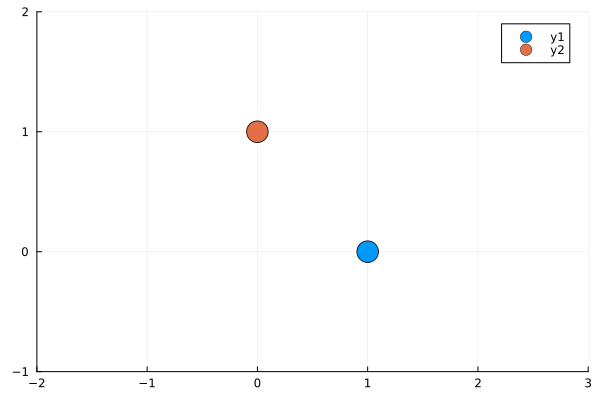

In [128]:
anim = @animate for t in 1:k_steps
    scatter([xhist[t, :][1]], [xhist[t, :][2]], m = (:circle, 12),
    xlims = (-2, 3), 
    ylims = (-1, 2), )
    scatter!([xhist[t, :][5]], [xhist[t, :][6]], m = (:circle, 12),
    xlims = (-2, 3), 
    ylims = (-1, 2), )
end every 10;
gif(anim, "pms.gif")